# Evidential Deep Learning for GammaTPC

This is one of the companion notebooks for the paper [Low-Energy Electron-Track Imaging for a Liquid Argon Time-Projection-Chamber Telescope Concept using Probabilistic Deep Learning](https://arxiv.org/abs/2207.07805) by M. Buuck, A. Mishra, E. Charles, N. Di Lalla, O. Hitchcock, M.E. Monzani, N. Omodei, and T. Shutt

This notebook will reproduce the plots related to the evidential deep learning analysis of electron track position finding presented in the paper. You can change the drift length from 5cm to 1cm or 10cm and see different results (although not for the last section).

In [1]:
#You might need to install this
#pip install evidential-deep-learning

In [31]:
import os
import pickle as pl
import datetime
import warnings

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import evidential_deep_learning as edl

In [3]:
golden_ratio = (1 + np.sqrt(5))/2

In [22]:
RERUN_MODEL = False
SAVE_FIGURES = True

## Data Imports

In [5]:
pitch = 0.2 #mm
drift = 5 #cm
noise = 1

In [7]:
filename = 'edl_inputs_{0}cm_drift.pkl'.format(drift)
with open(filename, 'rb') as f:
    data = pl.load(f)

Load pre-prepared training data. It consists of electron track samples (`x_train` and `x_test`), true initial electron scatter positions (origins; `y_train` and `y_test`), and true initial electron scatter directions (`z_train` and `z_test`). The initial scattering directions are not used in this notebook. The mean and standard deviation of the origins is also retrieved to facilitate normalization of the origins. We also extract the initial electron energies, which are not used in training but are used to make many of the subsequent plots.

In [8]:
x_train = np.expand_dims(data['x_train'], -1)
x_test = np.expand_dims(data['x_test'], -1)
y_train = data['y_train']
y_test = data['y_test']
input_shape = x_train.shape

o_std = data['o_std']
o_mean = data['o_mean']
samples_scale = data['samples_scale']

energies_test = [str(e)+' keV' for e in np.array(data['energies_test'], dtype=np.int64)]
energies_train = [str(e)+' keV' for e in np.array(data['energies_train'], dtype=np.int64)]

In [9]:
#Reshuffle the data
xtemp=np.concatenate([x_train, x_test], axis=0)
ytemp=np.concatenate([y_train, y_test], axis=0)
energiestemp = np.concatenate([energies_train, energies_test])

X_train, X_test, Y_train, Y_test, energies_train, energies_test = train_test_split(xtemp, ytemp, energiestemp, test_size=0.1, random_state=42)

origins = (Y_test*o_std+o_mean)

## Model Definitions And Training



In [10]:
factor=2
def coverage_metric(y_true, y_pred):
    meanpreds=y_pred[:,0:3]
    v=y_pred[:,3:6]
    alpha=y_pred[:,6:9]
    beta=y_pred[:,9:]
    stdpreds=tf.sqrt(beta/(v*(alpha-1)))

    n=tf.cast(tf.shape(y_true)[0], tf.int64)
    count=0
    w=0.0
    
    xrange=[meanpreds[:,0]-factor*stdpreds[:,0],meanpreds[:,0]+factor*stdpreds[:,0]]
    yrange=[meanpreds[:,1]-factor*stdpreds[:,1],meanpreds[:,1]+factor*stdpreds[:,1]]
    zrange=[meanpreds[:,2]-factor*stdpreds[:,2],meanpreds[:,2]+factor*stdpreds[:,2]]
        
    dx=2*factor*stdpreds[:,0]
    dy=2*factor*stdpreds[:,1]
    dz=2*factor*stdpreds[:,2]
    dl=tf.sqrt(dx*dx+dy*dy+dz*dz)
    w+=dl

    xt=y_true[:,0]
    yt=y_true[:,1]
    zt=y_true[:,2]

    count += tf.math.count_nonzero(tf.math.logical_and(tf.math.logical_and(tf.math.logical_and(xt>xrange[0], xt<xrange[1]), tf.math.logical_and(yt>yrange[0], yt<yrange[1])), tf.math.logical_and(zt>zrange[0], zt<zrange[1])))
            
    return count/n

In [11]:
def er_loss(true, pred):
    return edl.losses.EvidentialRegression(true, pred, coeff=2e-2)

In [12]:
def build_model():
    dim = x_train[0].shape[0]
    model = models.Sequential()
    model.add(layers.Conv3D(32, 3, activation='relu', input_shape=input_shape[1:]))
    model.add(layers.SpatialDropout3D(0.25))
    dim -= 2
    if dim>=18:
        model.add(layers.MaxPooling3D((2, 2, 2)))
        model.add(layers.BatchNormalization())
        dim /= 2


    model.add(layers.Conv3D(64, 3, activation='relu'))
    model.add(layers.SpatialDropout3D(0.25))
    dim -= 2
    if dim>=6:
        model.add(layers.MaxPooling3D((2, 2, 2)))
        model.add(layers.BatchNormalization())
        dim /= 2



    model.add(layers.Conv3D(128, 3, activation='relu'))
    model.add(layers.SpatialDropout3D(0.25))
    model.add(layers.BatchNormalization())


    model.add(layers.GlobalAveragePooling3D())
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(128))
    model.add(edl.layers.DenseNormalGamma(3))
    
    return model

In [21]:
if RERUN_MODEL:
    model=build_model()
    
    model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 28, 28, 28, 32)    896       
_________________________________________________________________
spatial_dropout3d (SpatialDr (None, 28, 28, 28, 32)    0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 14, 14, 14, 32)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 14, 32)    128       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 12, 12, 12, 64)    55360     
_________________________________________________________________
spatial_dropout3d_1 (Spatial (None, 12, 12, 12, 64)    0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 6, 6, 6, 64)       0

In [16]:
if RERUN_MODEL:
    epochs=1500
    tf.random.set_seed(42)
    model.compile(optimizer=tf.keras.optimizers.Adam(5e-5), loss=er_loss, metrics=[coverage_metric])
    log_dir = "/sdf/home/m/mbuuck/GammaTPC/machinelearning/logs/HeadUncertaintyStable_fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    history = model.fit(x_train, y_train, batch_size=128, epochs=epochs, validation_data=(x_test, y_test))
    model.save('HeadUncertaintyStable_model_drift{}'.format(drift))

Epoch 1/1500
134/134 [==============================] - 8s 33ms/step - loss: 1.4270 - coverage_metric: 0.9125 - val_loss: 1.4427 - val_coverage_metric: 0.5523
Epoch 2/1500
134/134 [==============================] - 4s 26ms/step - loss: 1.2711 - coverage_metric: 0.9489 - val_loss: 1.6919 - val_coverage_metric: 0.3855
Epoch 3/1500
134/134 [==============================] - 4s 26ms/step - loss: 1.1603 - coverage_metric: 0.9525 - val_loss: 1.7484 - val_coverage_metric: 0.2913
Epoch 4/1500
134/134 [==============================] - 3s 26ms/step - loss: 1.0609 - coverage_metric: 0.9475 - val_loss: 1.3383 - val_coverage_metric: 0.2987
Epoch 5/1500
134/134 [==============================] - 3s 26ms/step - loss: 0.9705 - coverage_metric: 0.9444 - val_loss: 0.8754 - val_coverage_metric: 0.5238
Epoch 6/1500
134/134 [==============================] - 3s 26ms/step - loss: 0.8824 - coverage_metric: 0.9376 - val_loss: 0.6810 - val_coverage_metric: 0.7928
Epoch 7/1500
134/134 [========================

INFO:tensorflow:Assets written to: HeadUncertaintyStable_model_drift5/assets


INFO:tensorflow:Assets written to: HeadUncertaintyStable_model_drift5/assets


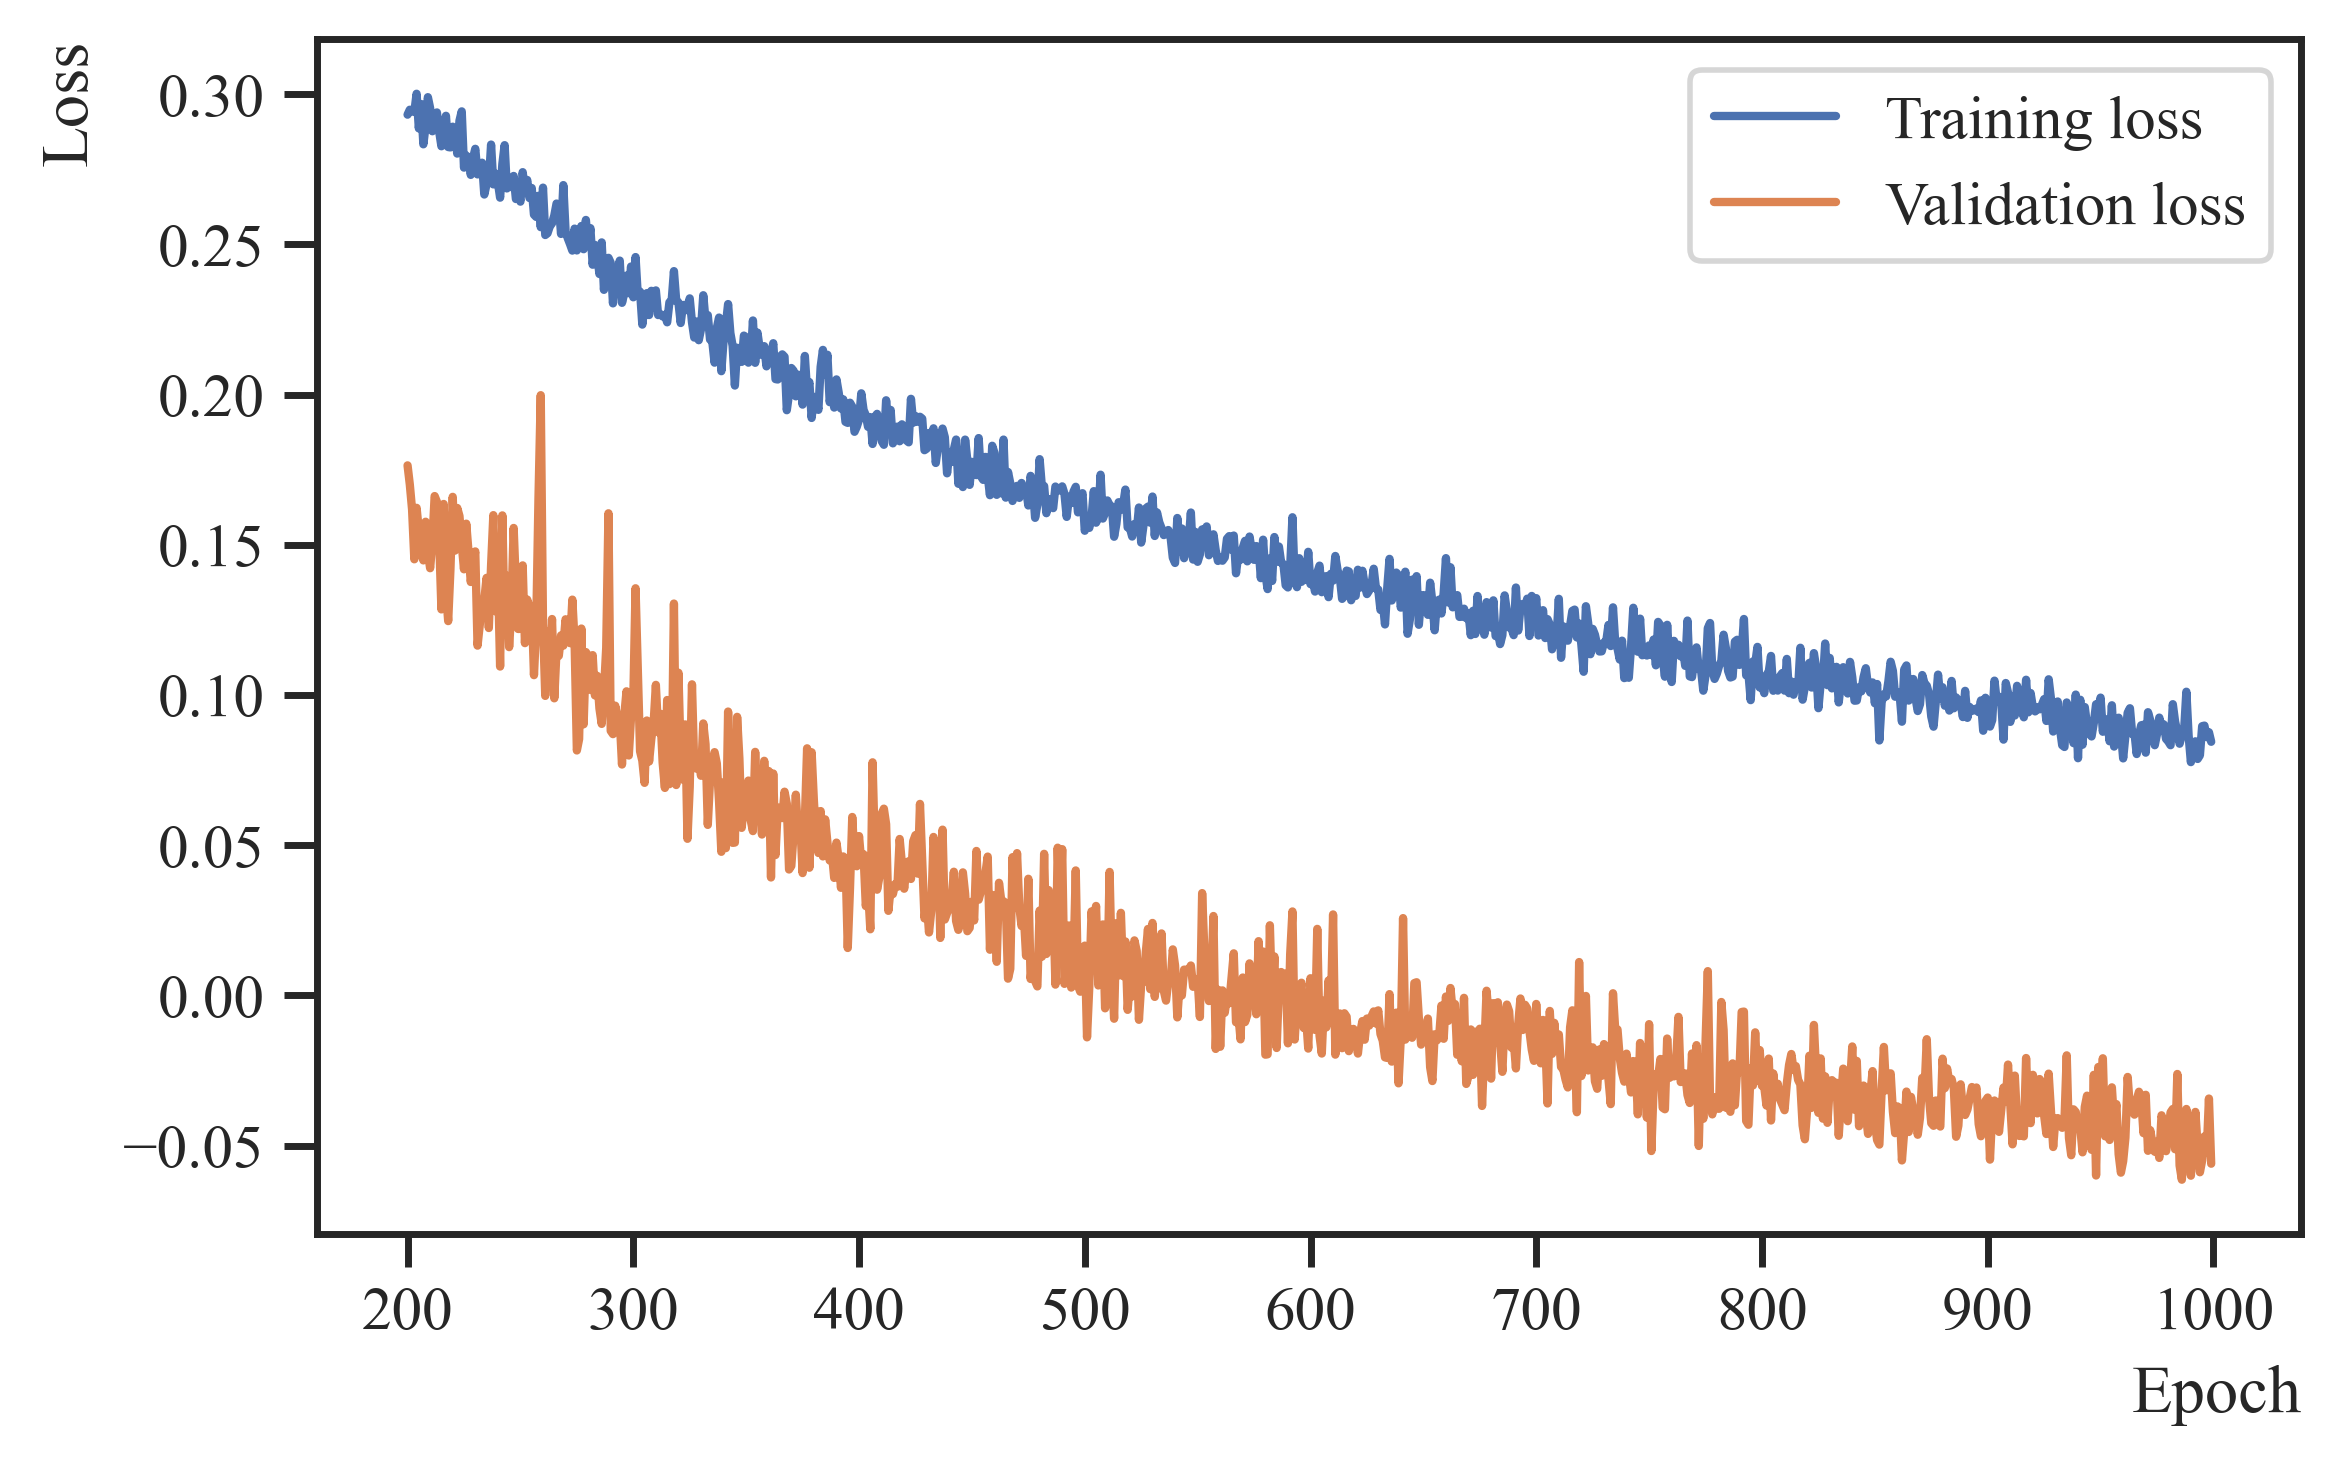

In [17]:
if RERUN_MODEL:
    sns.set_theme('notebook', 'ticks')
    plt.figure(dpi=400, figsize=(6.4, 6.4/golden_ratio))
    plt.plot(np.linspace(200,len(history.history["loss"])-1, len(history.history["loss"][200:])), history.history["loss"][200:], label='Training loss')
    plt.plot(np.linspace(200,len(history.history["loss"])-1, len(history.history["loss"][200:])), history.history["val_loss"][200:], label='Validation loss')
    plt.legend()
    plt.gca().set_xlabel("Epoch", loc='right')
    plt.gca().set_ylabel("Loss", loc='top')
    plt.show()

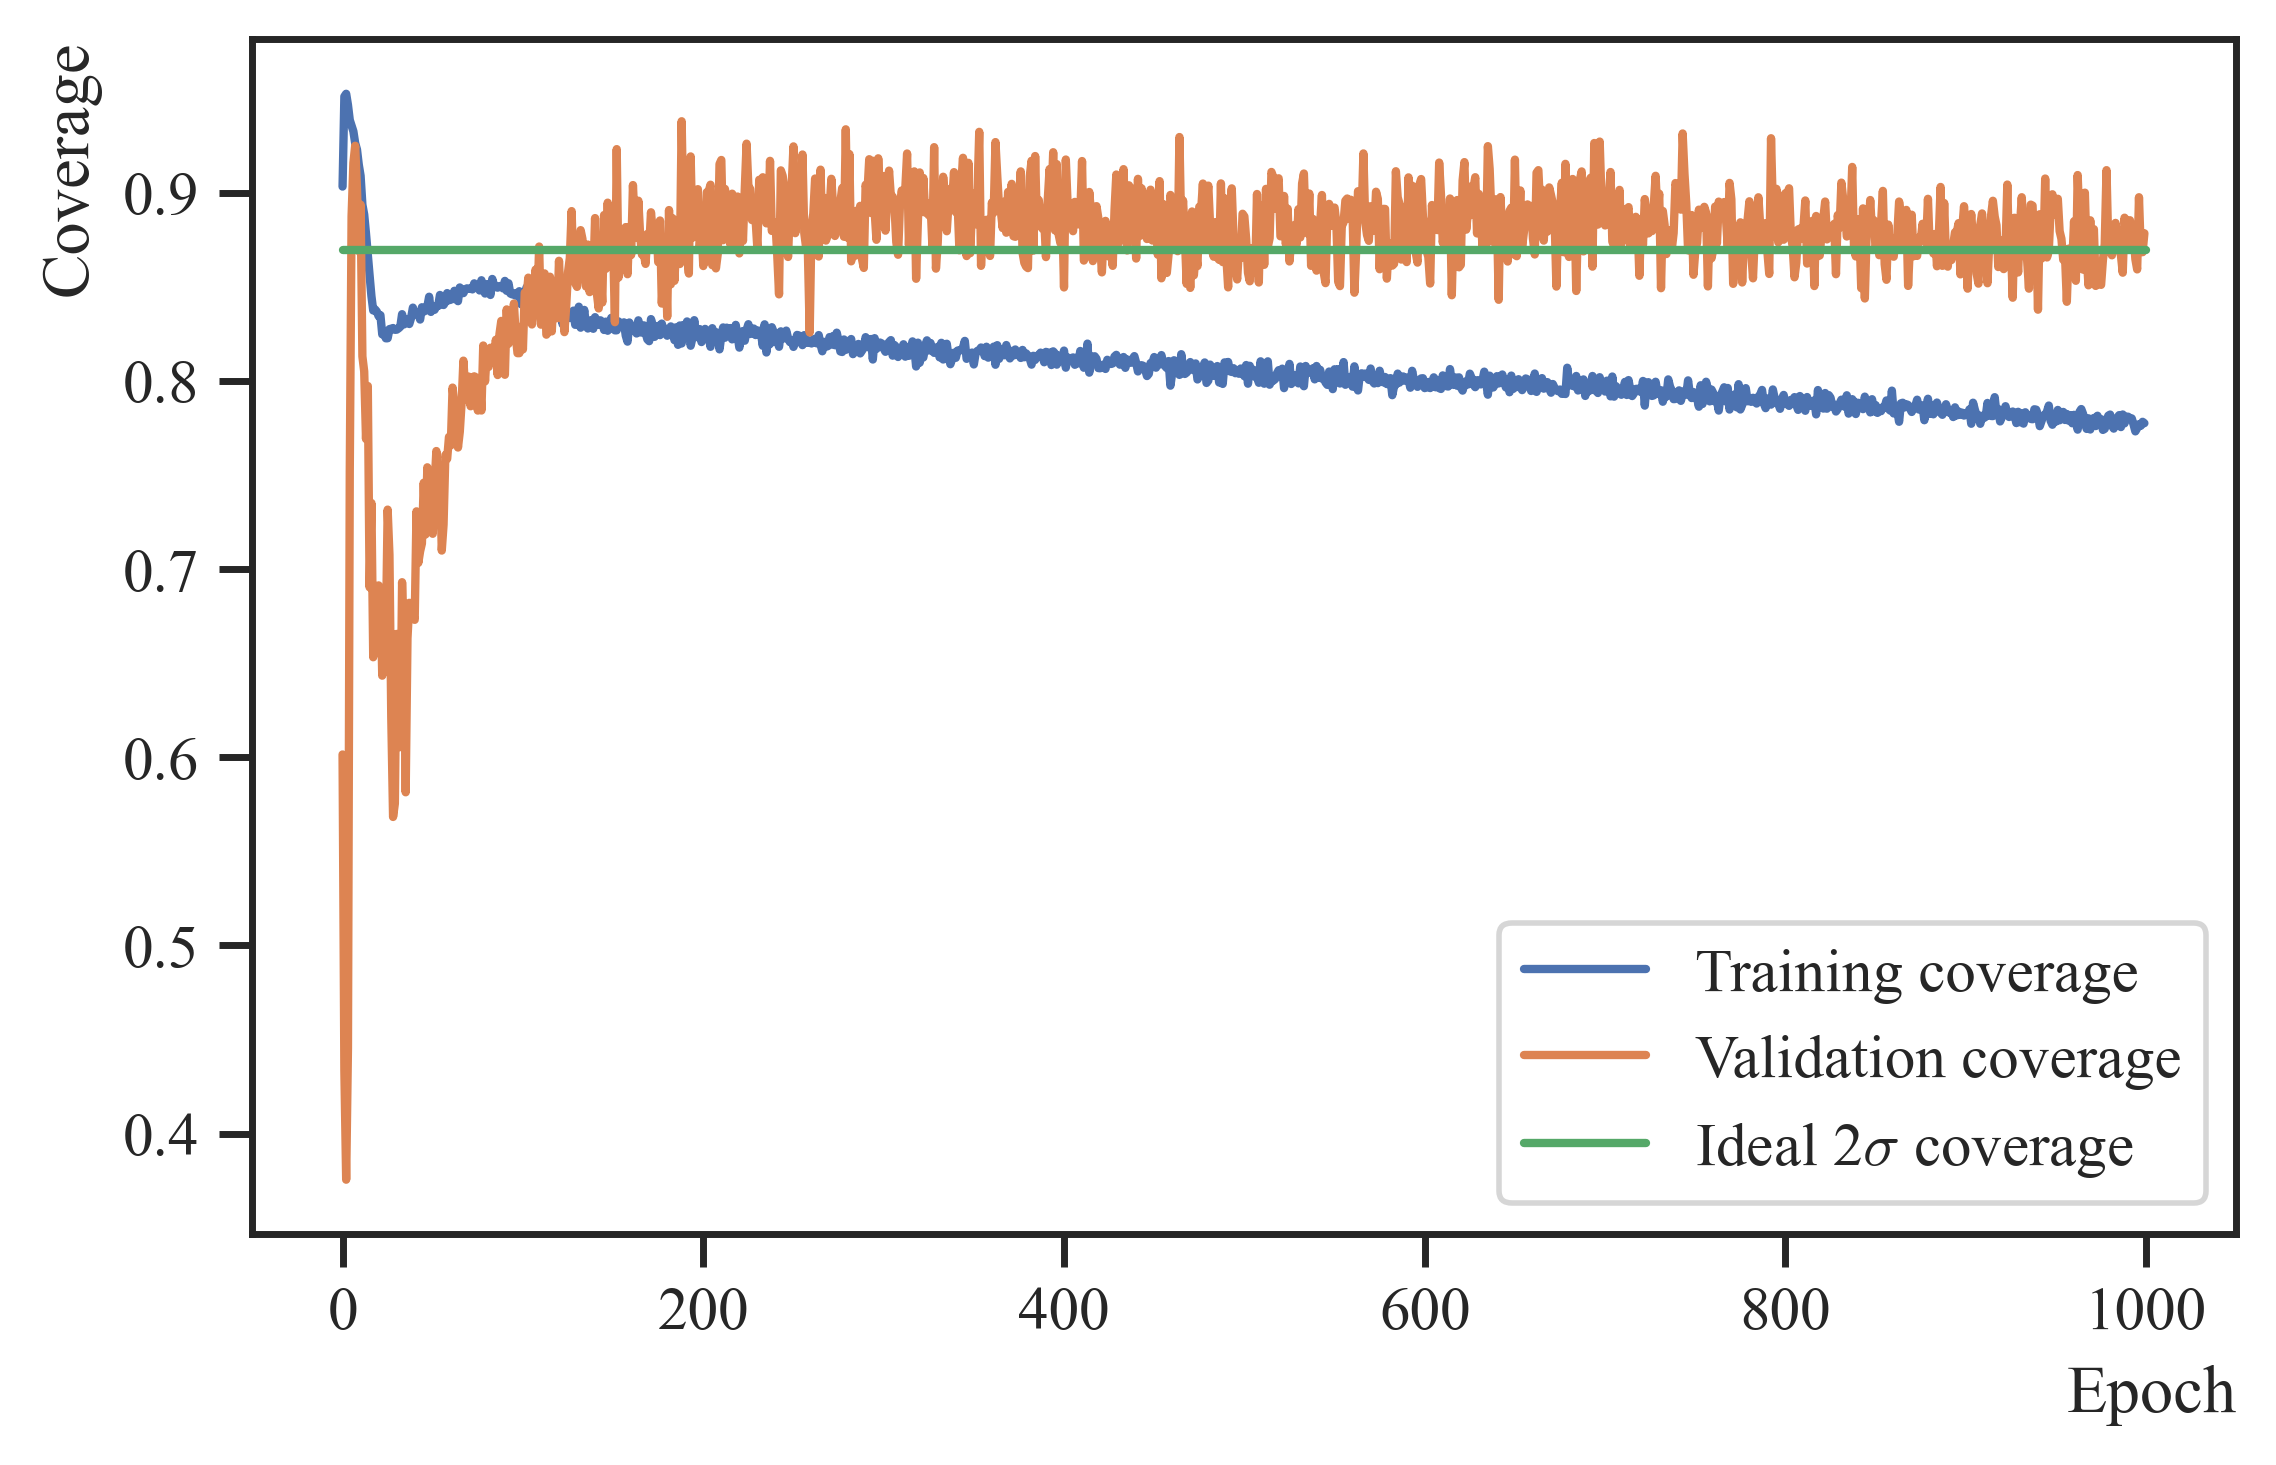

In [18]:
if RERUN_MODEL:
    sns.set_theme('notebook', 'ticks')
    plt.figure(dpi=400, figsize=(6.4, 6.4/golden_ratio))
    plt.plot(history.history["coverage_metric"], label='Training coverage')
    plt.plot(history.history["val_coverage_metric"], label='Validation coverage')
    plt.plot(np.linspace(0,epochs,epochs), np.full(epochs,(scipy.stats.norm.cdf(factor) - scipy.stats.norm.cdf(-factor))**3), label='Ideal 2$\sigma$ coverage')
    plt.legend()
    plt.gca().set_xlabel("Epoch", loc='right')
    plt.gca().set_ylabel("Coverage", loc='top')
    plt.show()

In [14]:
if not RERUN_MODEL:
    model = keras.models.load_model('HeadUncertaintyStable_model_drift{}'.format(drift),custom_objects={'coverage_metric':coverage_metric, 'er_loss':er_loss})
    model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 28, 28, 28, 32)    896       
_________________________________________________________________
spatial_dropout3d (SpatialDr (None, 28, 28, 28, 32)    0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 14, 14, 14, 32)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 14, 32)    128       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 12, 12, 12, 64)    55360     
_________________________________________________________________
spatial_dropout3d_1 (Spatial (None, 12, 12, 12, 64)    0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 6, 6, 6, 64)       0

## Make predictions and test

In [15]:
def get_mean_stddev_predictions(model, X_test):
    y_pred=model(X_test)
    Meanpred=y_pred[:,0:3].numpy()
    v=y_pred[:,3:6].numpy()
    alpha=y_pred[:,6:9].numpy()
    beta=y_pred[:,9:].numpy()
    Stdpred=np.sqrt(beta/(v*(alpha-1)))
    return Meanpred, Stdpred

In [16]:
def coverage(truevalues, meanpreds, stdpreds, factor=2.0):
    #the factor parameters determines the interval, so factor =1 tests the 1 sigma interval, factor =3 tests the 3 sigma
    #at factor =2, we should get around 85% coverage ideally.
    n=truevalues.shape[0]
    count=0
    w=0.0
    
    for i in range(n):
        xrange=[meanpreds[i,0]-factor*stdpreds[i,0],meanpreds[i,0]+factor*stdpreds[i,0]]
        yrange=[meanpreds[i,1]-factor*stdpreds[i,1],meanpreds[i,1]+factor*stdpreds[i,1]]
        zrange=[meanpreds[i,2]-factor*stdpreds[i,2],meanpreds[i,2]+factor*stdpreds[i,2]]
        
        dx=2*factor*stdpreds[i,0]
        dy=2*factor*stdpreds[i,1]
        dz=2*factor*stdpreds[i,2]
        dl=np.sqrt(dx*dx+dy*dy+dz*dz)
        w+=dl
        
        xt=truevalues[i,0]
        yt=truevalues[i,1]
        zt=truevalues[i,2]
        
        if (xt>xrange[0] and xt<xrange[1]) and (yt>yrange[0] and yt<yrange[1]) and (zt>zrange[0] and zt<zrange[1]):
            count+=1
            
    return count/n, w/n

In [17]:
Meanpred, Stdpred = get_mean_stddev_predictions(model, X_test)

In [18]:
predictions = (Meanpred*o_std) + o_mean
pred_errors = (Stdpred*o_std) + o_mean

In [19]:
errors = origins-predictions
error = 'Error (mm)'
squared_error = 'Sq Error (mm${}^2$)'
abs_error = 'Abs Error (mm)'
z_score_name = 'Z score'
pred_error = 'Predicted Abs Error (mm)'
pred_sq_error = 'Predicted Sq Error (mm${}^2$)'
energy = 'Initial Electron Energy'
df0 = pd.DataFrame(data={'X '+error:errors[:,0]*1000, 'Y '+error:errors[:,1]*1000, 'Z '+error:errors[:,2]*1000, energy: energies_test})
df1 = pd.DataFrame(data={error:errors.flatten()*1000, squared_error:((errors - np.mean(errors, axis=0)).flatten()*1000)**2, abs_error:np.sqrt(((errors- np.mean(errors, axis=0)).flatten()*1000)**2), pred_error:pred_errors.flatten()*1000, pred_sq_error:(pred_errors.flatten()*1000)**2, z_score_name:errors.flatten()/pred_errors.flatten(), energy:np.repeat(energies_test, 3)})

In [20]:
def centered_parabola(x, a, b):
    return a**2*x**2 + b

In [21]:
pal1 = sns.color_palette('Paired')[0::2][:5]#len(np.unique(df.Energy)))
pal2 = sns.color_palette('Paired')[1::2][:5]
pal3 = sns.color_palette('Dark2')

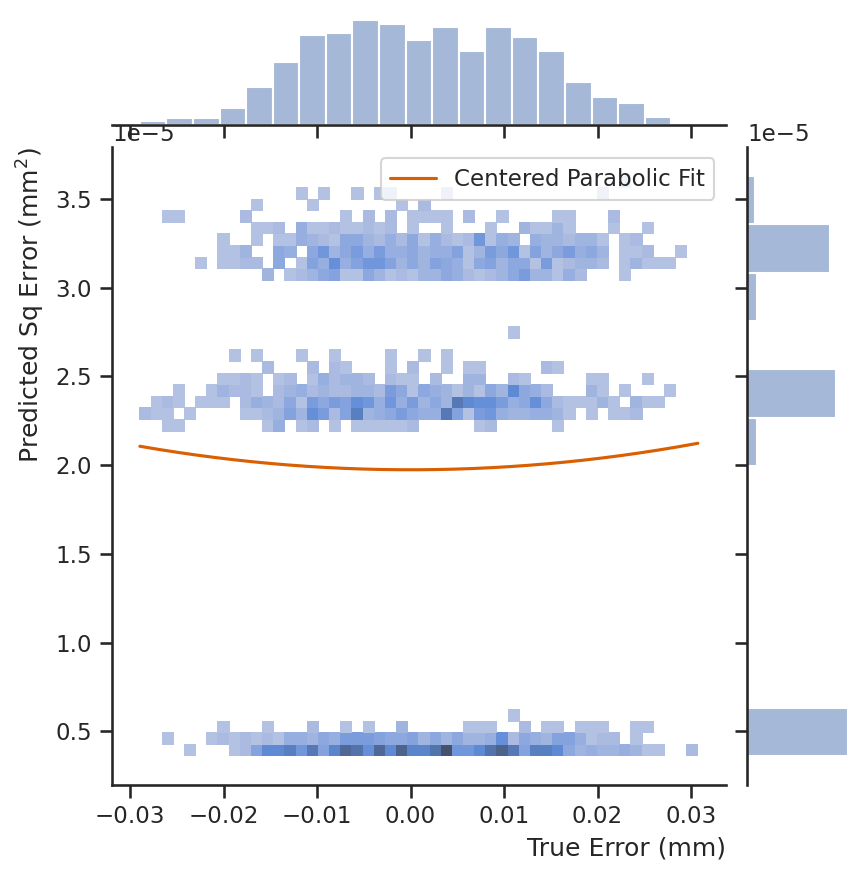

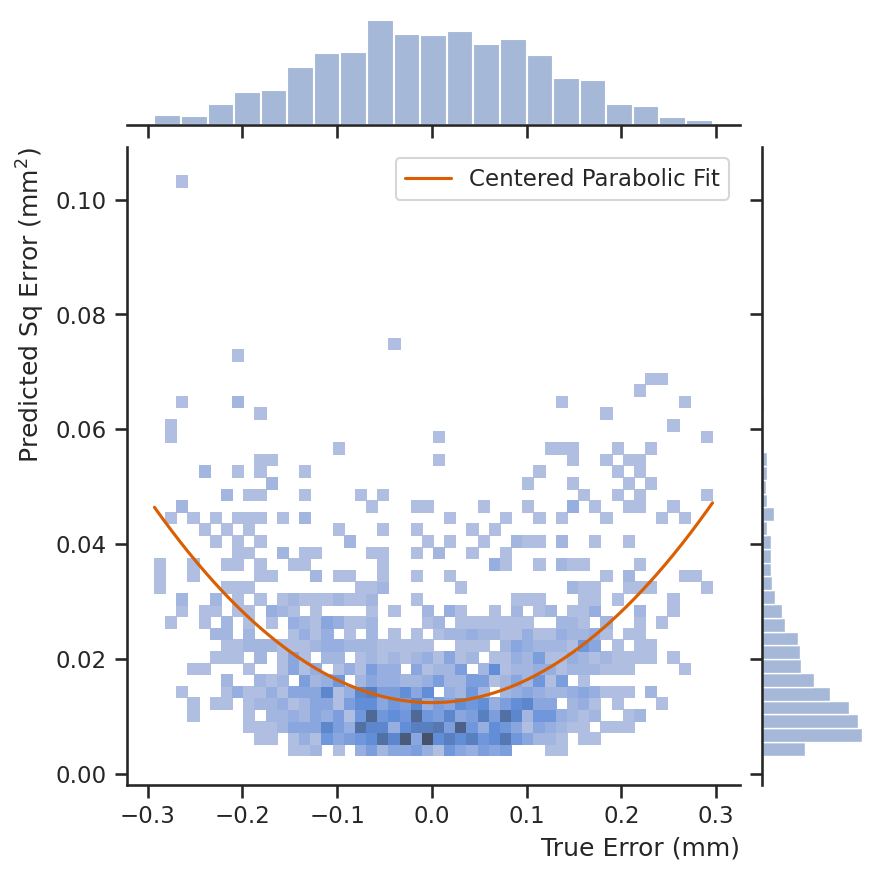

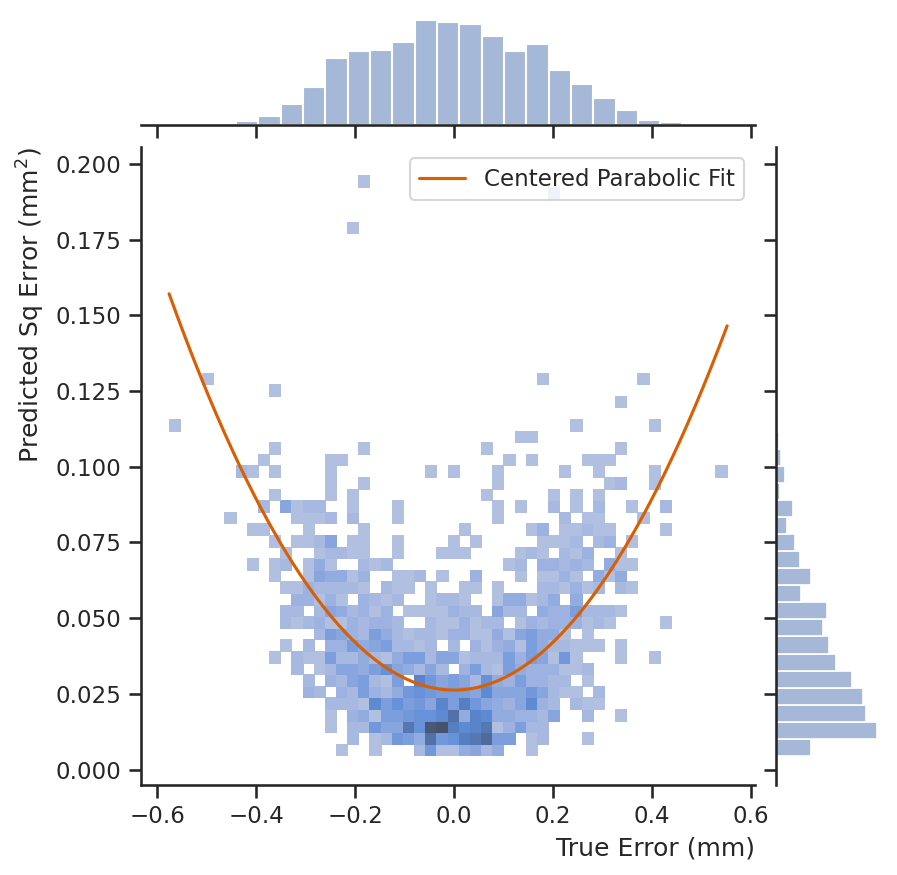

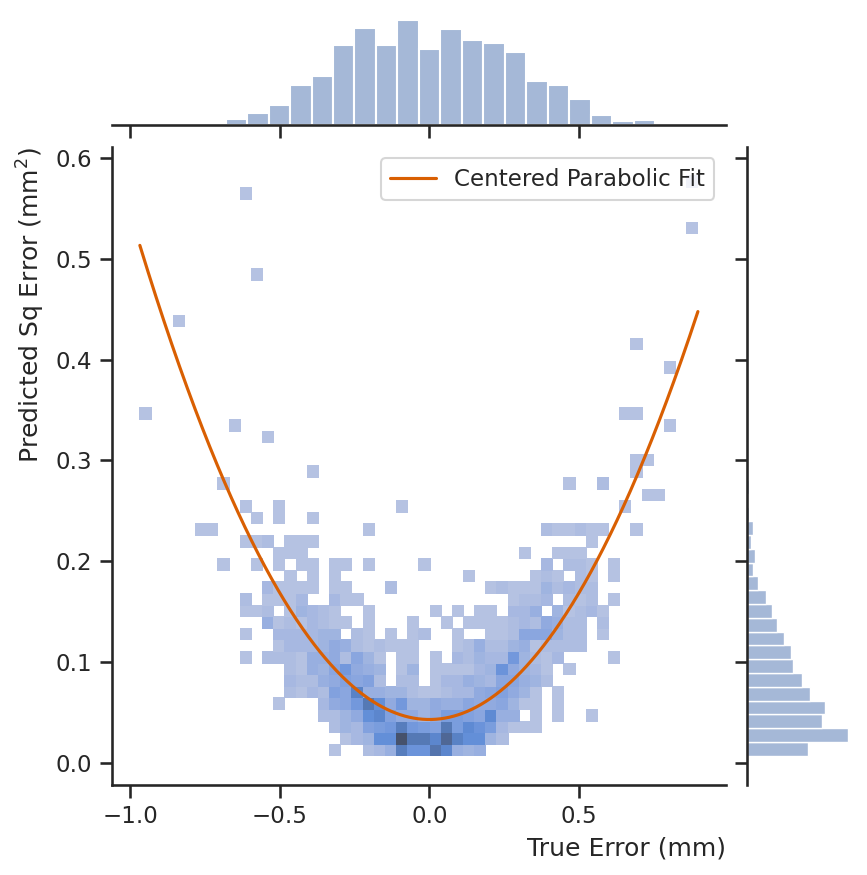

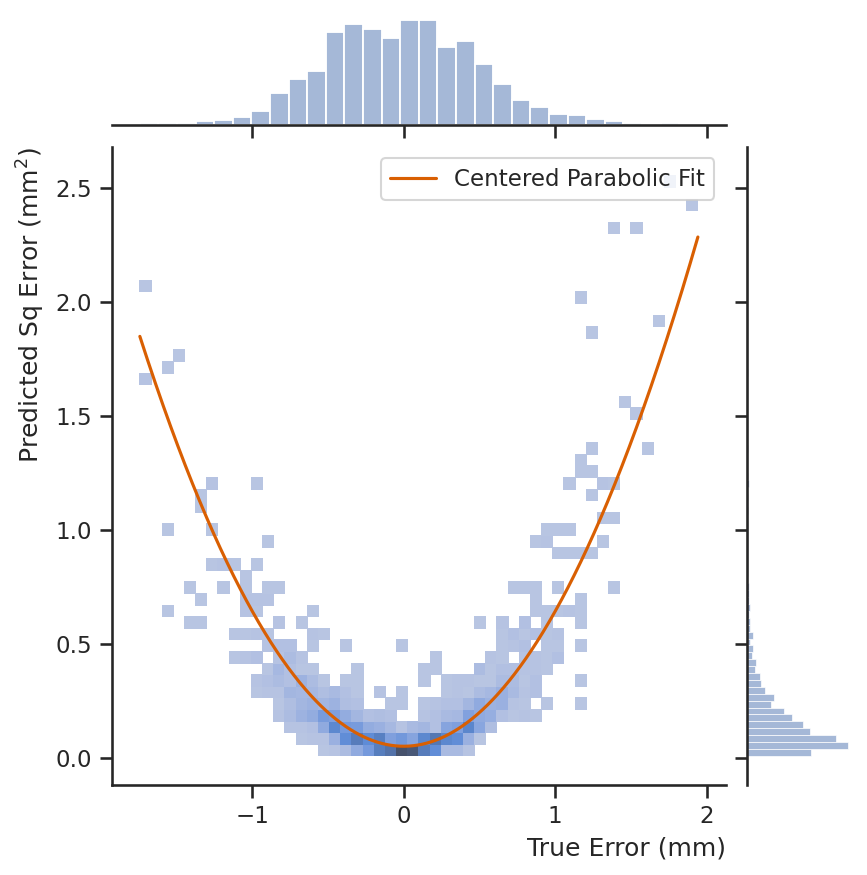

In [45]:
context='notebook'
style='ticks'
fmt='png'
fig_dpi=150
sns.set_theme(context, style)

hue_order = ['50 keV', '300 keV', '500 keV', '750 keV', '1000 keV']
for en in hue_order:
    x_cutoff = 10
    y_cutoff = 10
    if en=='300 keV':
        x_cutoff = 0.3
        y_cutoff = 0.15
    elif en=='500 keV':
        y_cutoff = 0.25
    df_tmp = df1[(df1[energy]==en)&(df1[error]<x_cutoff)&(df1[error]>-x_cutoff)&(df1[pred_sq_error]<y_cutoff)]
    para_popt, para_pcorr = scipy.optimize.curve_fit(centered_parabola, df_tmp[error], df_tmp[pred_sq_error])    
    g = sns.jointplot(data=df_tmp, x=error, y=pred_sq_error, kind='hist', color=pal2[0], bins=50, hue=energy, legend=False)
    x = np.linspace(np.maximum(-x_cutoff, df_tmp[error].min()), np.minimum(x_cutoff, df_tmp[error].max()), 1000)
    g.ax_joint.plot(x, centered_parabola(x, *para_popt), color=pal3[1], label='Centered Parabolic Fit')
    g.ax_joint.set_xlabel("True Error (mm)", loc='right')
    g.ax_joint.set_ylabel(g.ax_joint.get_ylabel(), loc='top')
    g.figure.set_dpi(fig_dpi)
    if context!='poster':
        g.ax_joint.legend()
    if SAVE_FIGURES:
        plt.savefig("predicted_vs_actual_sq_error_{0}_{1}_{2}.{3}".format(en, context, style, fmt), format=fmt)
    plt.show()

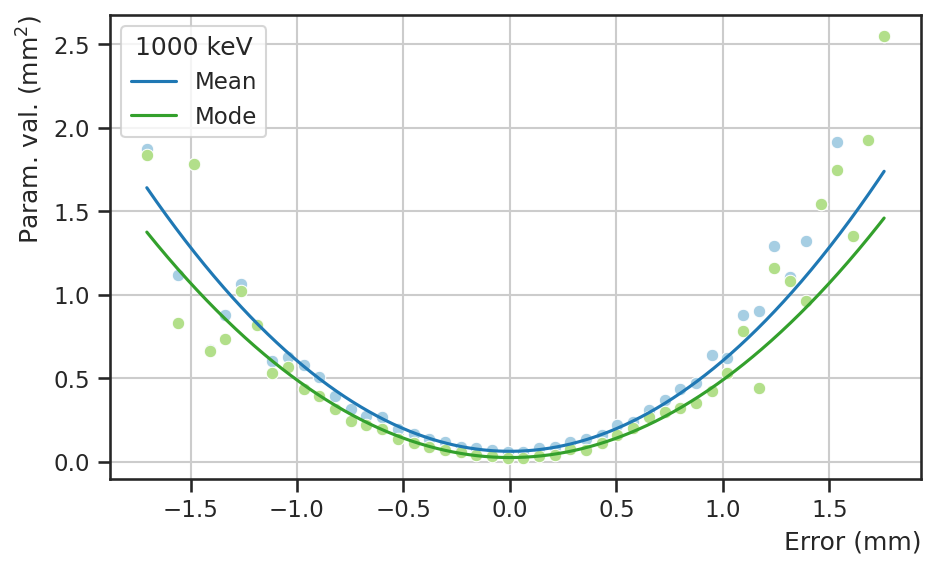

In [46]:
context = 'notebook'
style = 'ticks'
fmt='png'
sns.set_theme(context, style)
fig_dpi=150

mean_popts = {}
mode_popts = {}
fig, ax = plt.subplots(1,1, dpi=fig_dpi, figsize = (6.4, 6.4/golden_ratio))

for en in ['50 keV', '300 keV', '500 keV', '750 keV', '1000 keV']:
    params = []
    sigmas = []
    xb = []
    cutoff = 2
    if en=='300 keV':
        cutoff = 0.4
    df_tmp = df1[(df1[energy]==en)&(df1[abs_error]<cutoff)]
    counts, xbins, ybins = np.histogram2d(df_tmp[error], df_tmp[pred_sq_error], bins=50)
    for i in range(len(xbins)-1):
        df_tmp1 = df_tmp[(df_tmp[error]<xbins[i+1])&(df_tmp[error]>xbins[i])]
        if df_tmp1.shape[0]==0:
            continue
        x = np.linspace(0,np.max(df1[pred_sq_error]), 100)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            params.append(scipy.stats.invgamma.fit(df_tmp1[pred_sq_error], floc=0))
            sigmas.append(1/np.sum(counts[i]))
        xb.append((xbins[i+1]+xbins[i])/2)

    params = np.array(params)
    xb = np.array(xb)
    sigmas = np.array(sigmas)
    fitfunc = centered_parabola
    mean_popt, mean_pcorr = scipy.optimize.curve_fit(fitfunc, xb, params[:,2]/(params[:,0]-1), sigma=sigmas, absolute_sigma=True)
    mean_popts[en] = mean_popt
    mode_popt, mode_pcorr = scipy.optimize.curve_fit(fitfunc, xb, params[:,2]/(params[:,0]+1), sigma=sigmas, absolute_sigma=True)
    mode_popts[en] = mode_popt
    
    if en=='1000 keV':
        sns.scatterplot(ax=ax, x=xb, y=params[:,2]/(params[:,0]-1), color=pal1[0])
        sns.scatterplot(ax=ax, x=xb, y=params[:,2]/(params[:,0]+1), color=pal1[1])
        x = np.linspace(xb[0], xb[-1], 1000)
        ax.plot(x, fitfunc(x, *mean_popt), color=pal2[0], label='Mean')
        ax.plot(x, fitfunc(x, *mode_popt), color=pal2[1], label='Mode')
        ax.set_ylabel('Param. val. (mm${}^2$)', loc='top')
        ax.set_xlabel(error, loc='right')
        ax.legend(title=en)
        plt.grid('major')
        plt.tight_layout()
        if SAVE_FIGURES:
            plt.savefig("InvGamma_param_fits_{0}_{1}.{2}".format(context, style, fmt), format=fmt)

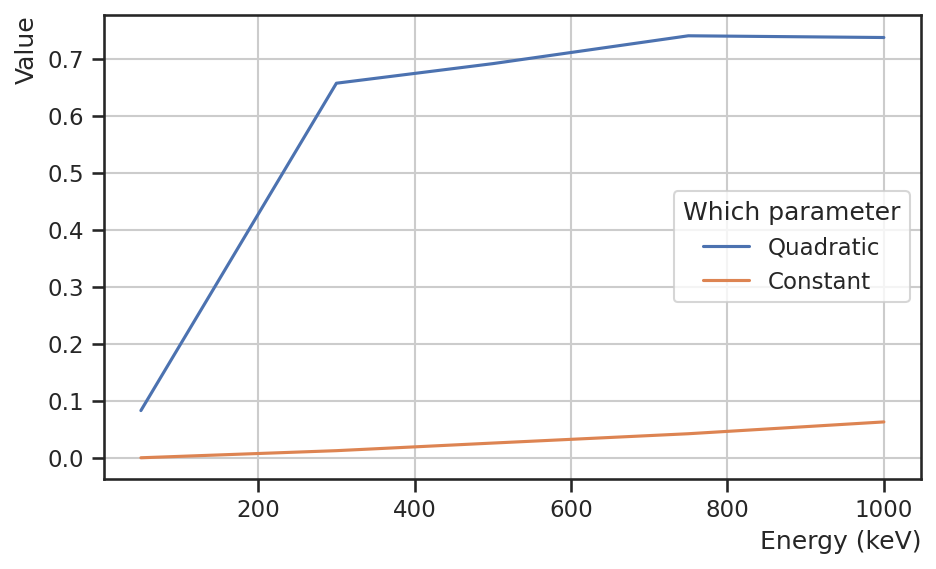

In [47]:
context = 'notebook'
style = 'ticks'
fmt='png'
sns.set_theme(context, style)
fig_dpi=150

fig, ax = plt.subplots(1,1, dpi=fig_dpi, figsize = (6.4, 6.4/golden_ratio))

x = np.array([50, 300, 500, 750, 1000])
para_mean = np.array([mean_popts[str(en)+' keV'] for en in x])
a = ax.plot(x, para_mean[:, 0], label='Quadratic')
a = ax.plot(x, para_mean[:, 1], label='Constant')
plt.legend(title='Which parameter')
ax.set_xlabel('Energy (keV)', loc='right')
ax.set_ylabel('Value', loc='top')
plt.grid('major')
plt.tight_layout()
if SAVE_FIGURES:
    plt.savefig("Inv_gamma_parabola_mean_params_{0}_{1}.{2}".format(context, style, fmt), format=fmt)

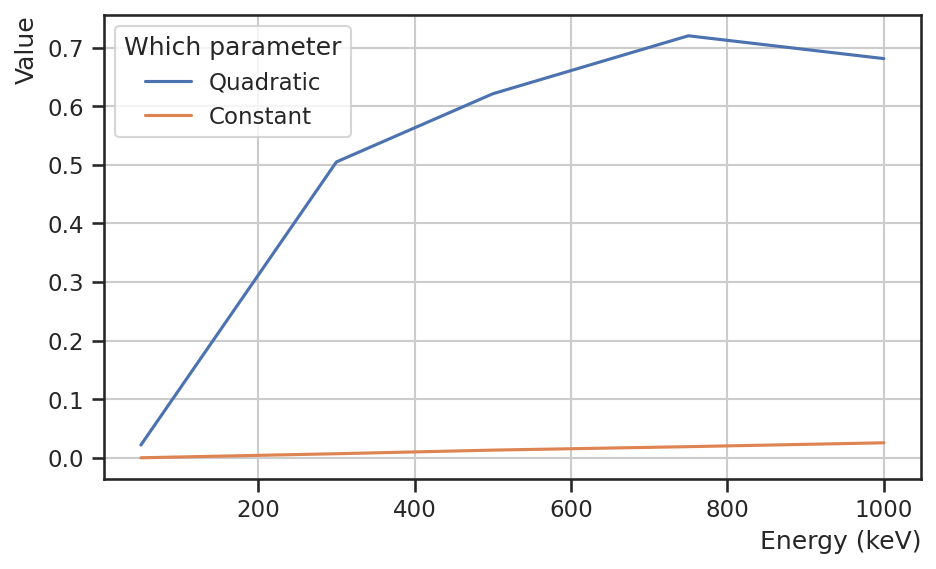

In [49]:
context = 'notebook'
style = 'ticks'
fmt='png'
sns.set_theme(context, style)
fig_dpi=150

fig, ax = plt.subplots(1,1, dpi=fig_dpi, figsize = (6.4, 6.4/golden_ratio))

x = np.array([50, 300, 500, 750, 1000])
para_mode = np.array([mode_popts[str(en)+' keV'] for en in x])
a = ax.plot(x, para_mode[:, 0], label='Quadratic')
a = ax.plot(x, para_mode[:, 1], label='Constant')
plt.legend(title='Which parameter')
ax.set_xlabel('Energy (keV)', loc='right')
ax.set_ylabel('Value', loc='top')
plt.grid('major')
plt.tight_layout()
if SAVE_FIGURES:
    plt.savefig("Inv_gamma_parabola_mode_params_{0}_{1}.{2}".format(context, style, fmt), format=fmt)

True absolute error of 0.6217081224302873 mm
Fitted: x = 0.6411360101433274 mean = 0.2837666220973578 mode = 0.22238398615375166
Interpolated: x = 0.6411360101433274 mean = 0.2860854313441641 mode = 0.21645610219068973
0.2860854313441641 0.21645610219068973


/opt/conda/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2494: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


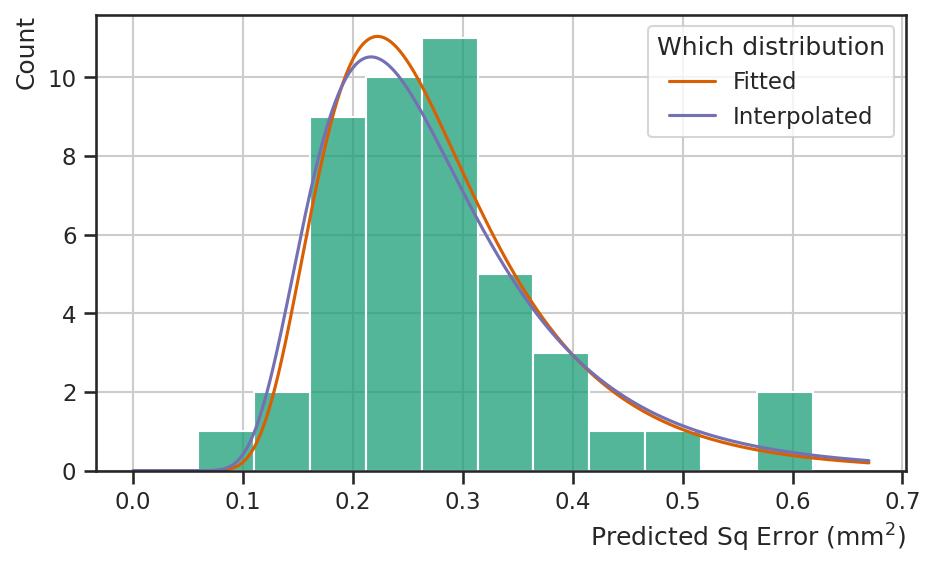

In [50]:
context = 'notebook'
style = 'ticks'
sns.set_theme(context, style)
fmt='png'
fig_dpi=150

plt.figure(dpi=fig_dpi, figsize=(6.4, 6.4/golden_ratio))

en = '1000 keV'
i=16
cutoff = 4
if en=='300 keV':
    cutoff = 0.5
df_tmp = df1[(df1[energy]==en)]
counts, xbins, ybins = np.histogram2d(df_tmp[abs_error], df_tmp[pred_sq_error], bins=50)
print('True absolute error of', xbins[i], 'mm')
df_tmp1 = df_tmp[(df_tmp[abs_error]<xbins[i+1])&(df_tmp[abs_error]>xbins[i])]

max_x = len(counts[15]) - np.argmin(counts[15][::-1]==0)
x = np.linspace(0,ybins[max_x], 1000)

ax = sns.histplot(data=df_tmp1, x=pred_sq_error, bins=ybins[:max_x], color=pal3[0])
ax.set_xlabel(pred_sq_error, loc='right')
ax.set_ylabel('Count', loc='top')
params = scipy.stats.invgamma.fit(df_tmp1[pred_sq_error], floc=0)
plt.plot(x, df_tmp1[pred_sq_error].shape[0]*(ybins[i+1]-ybins[i])*scipy.stats.invgamma.pdf(x, *params), color=pal3[1], label='Fitted')
print('Fitted: x =', (xbins[i+1]+xbins[i])/2, 'mean =', params[2]/(params[0]-1), 'mode =', params[2]/(params[0]+1))

mode = fitfunc((xbins[i+1]+xbins[i])/2, *mode_popts[en])
mean = fitfunc((xbins[i+1]+xbins[i])/2, *mean_popts[en])
print('Interpolated: x =', (xbins[i+1]+xbins[i])/2, 'mean =', mean, 'mode =', mode)
alpha = (mean+mode)/(mean-mode)
beta = mode*(alpha+1)
print(mean, mode)
plt.plot(x, df_tmp1[pred_sq_error].shape[0]*(ybins[i+1]-ybins[i])*scipy.stats.invgamma.pdf(x, alpha, 0, beta), color=pal3[2], label='Interpolated')
plt.legend(title='Which distribution')
plt.grid('major')
plt.tight_layout()
if SAVE_FIGURES:
    plt.savefig("Inv_gamma_dist_{0}_{1}.{2}".format(context, style, fmt), format=fmt)

50 keV
    mu: 1.397e-03 +- 2.808e-04
    sigma (68% CI) 1.113e-02 (1.094e-02, 1.133e-02)

300 keV
    mu: -4.710e-03 +- 3.761e-03
    sigma (68% CI) 1.424e-01 (1.398e-01, 1.451e-01)

500 keV
    mu: -8.170e-03 +- 4.541e-03
    sigma (68% CI) 1.731e-01 (1.700e-01, 1.765e-01)

750 keV
    mu: -3.452e-03 +- 7.569e-03
    sigma (68% CI) 2.814e-01 (2.762e-01, 2.869e-01)

1000 keV
    mu: -1.739e-02 +- 1.324e-02
    sigma (68% CI) 5.127e-01 (5.036e-01, 5.223e-01)



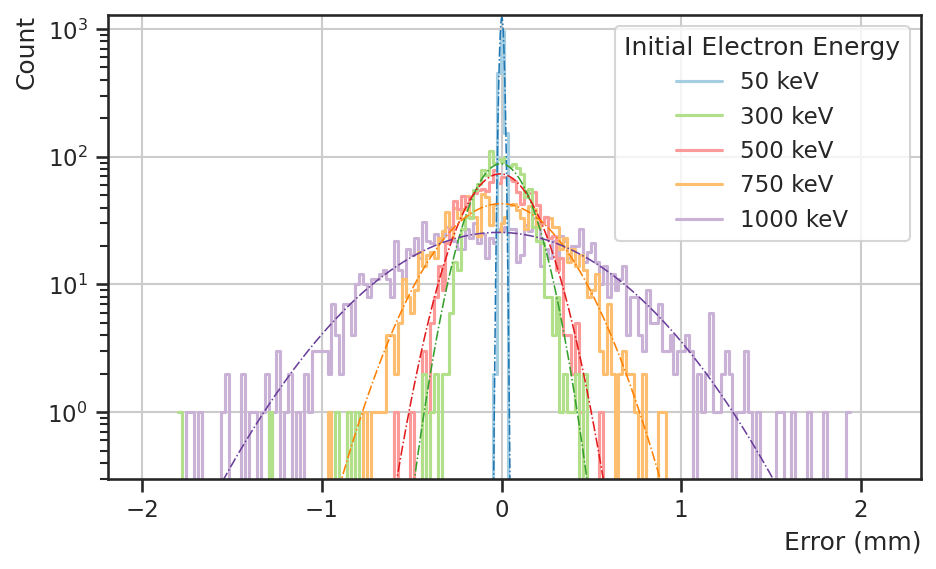

In [51]:
context = 'notebook'
style='ticks'
fmt='png'
sns.set_theme(context, style)
fig_dpi=150

plt.figure(dpi=fig_dpi, figsize=(6.4, 6.4/golden_ratio))
hue_order = ['50 keV', '300 keV', '500 keV', '750 keV', '1000 keV']
ax = sns.histplot(data=df1, x=error, hue=energy, element='step', fill=False, palette=pal1, hue_order=hue_order)
bin_width = np.diff(ax.get_lines()[0].get_xdata())[0]
x = np.linspace(ax.get_xlim()[0], ax.get_xlim()[-1], 20001)
i=0
fit_params_all_energies = {}
for en in hue_order:
    fit_params = scipy.stats.norm.fit(df1[(df1[energy]==en)][error])
    fit_params_all_energies[en] = fit_params
    plt.plot(x, df1[(df1[energy]==en)].shape[0]*bin_width*scipy.stats.norm.pdf(x, *fit_params), '-.', linewidth=0.75, c=pal2[i])
    alpha = 1-(scipy.stats.norm.cdf(1) - scipy.stats.norm.cdf(-1))
    n = df1[(df1[energy]==en)].shape[0]
    print(en)
    print("    mu: {0:.3e} +- {1:.3e}".format(fit_params[0], scipy.stats.t.ppf(1-alpha/2, n-1)/np.sqrt(n)*fit_params[1]))
    print("    sigma ({0:.0f}% CI) {1:.3e} ({2:.3e}, {3:.3e})\n".format(100*(1-alpha), fit_params[1], np.sqrt((n-1)*fit_params[1]**2/scipy.stats.chi2.ppf(1-alpha/2, n-1)), np.sqrt((n-1)*fit_params[1]**2/scipy.stats.chi2.ppf(alpha/2, n-1))))
    i += 1
ax.set_xlabel(ax.get_xlabel(), loc='right')
ax.set_ylabel(ax.get_ylabel(), loc='top')
ax.set_ylim([0.3,ax.get_ylim()[-1]])
if context=='talk':
    plt.legend(ax.get_legend().legendHandles, hue_order, title=energy, title_fontsize=12, fontsize=12)
ax.set_yscale('log')
plt.grid('major')
plt.tight_layout()
if SAVE_FIGURES:
    plt.savefig("edl_fitted_mean_error_distributions_5_cm_drift_{0}_{1}.{2}".format(context, style, fmt), format=fmt)
plt.show()

50 keV mean absolute error: 0.01857309082529089
300 keV mean absolute error: 0.20615192674787747
500 keV mean absolute error: 0.28793117934221185
750 keV mean absolute error: 0.4682588212067833
1000 keV mean absolute error: 0.8323624248034277


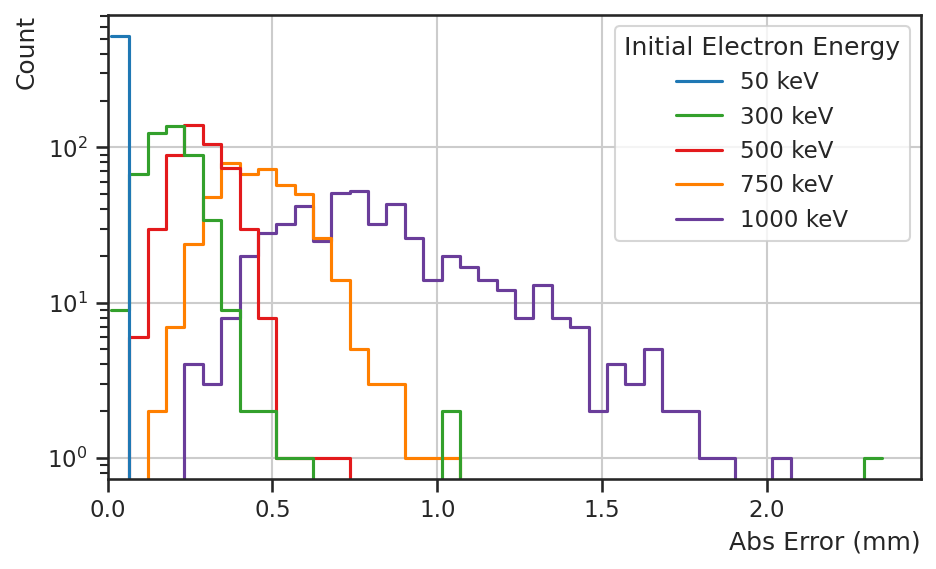

In [66]:
context = 'notebook'
style = 'ticks'
fmt='png'
sns.set_theme(context, style)
fig_dpi=150

plt.figure(dpi=fig_dpi, figsize=(6.4, 6.4/golden_ratio))
hue_order = ['50 keV', '300 keV', '500 keV', '750 keV', '1000 keV']

ax = sns.histplot(data=df_abs, x=abs_error, hue=energy, element='step', fill=False, palette=pal2, hue_order=hue_order)
for en in hue_order:
    print(en, "mean absolute error:", df_abs[df_abs[energy]==en][abs_error].mean())

ax.set_xlabel(ax.get_xlabel(), loc='right')
ax.set_ylabel(ax.get_ylabel(), loc='top')
ax.set_xlim([0, ax.get_xlim()[1]])
ax.set_yscale('log')
ax.grid(which='major')
plt.tight_layout()
if SAVE_FIGURES:
    plt.savefig("edl_5_cm_drift_abs_error_distributions_{0}_{1}.{2}".format(context,style, fmt), format=fmt)
plt.show()

Print the squared error so that it can be plotted in the summary plot in `2022_summary_plots.ipynb`

In [ ]:
for en in hue_order:
    print(en, "mean squared error:", df_abs[df_abs[energy]==en][squared_error].mean())

In [52]:
def get_mean_std(errors, sigma=1, verbose=False):
    fit_params = scipy.stats.norm.fit(errors)
    alpha = 1-(scipy.stats.norm.cdf(sigma) - scipy.stats.norm.cdf(-sigma))
    n = errors.shape[0]
    mean = (fit_params[0], scipy.stats.t.ppf(1-alpha/2, n-1)/np.sqrt(n)*fit_params[1])
    std = (fit_params[1], np.sqrt((n-1)*fit_params[1]**2/scipy.stats.chi2.ppf(1-alpha/2, n-1)), np.sqrt((n-1)*fit_params[1]**2/scipy.stats.chi2.ppf(alpha/2, n-1)))
    if verbose:
        print("    mu: {0:.3e} +- {1:.3e}".format(*mean))
        print("    sigma ({0:.0f}% CI) {1:.3e} ({2:.3e}, {3:.3e})\n".format(100*(1-alpha), *std))

    return mean, std, n

In [53]:
mses = df0['X Error (mm)']**2 + df0['Y Error (mm)']**2 + df0['Z Error (mm)']**2
rmses = np.sqrt(mses)
unc_rms = pd.Series(np.sqrt(np.sum((Stdpred*o_std+o_mean)**2, axis=1)))*1000
chi2 = unc_rms/rmses
ind = np.linspace(0, len(df0[energy])-1, len(df0[energy])).astype(int)
sorted_errs = ind[rmses.sort_values().index]
sorted_uncs = ind[unc_rms.sort_values().index]
sorted_chi2 = ind[chi2.sort_values().index]

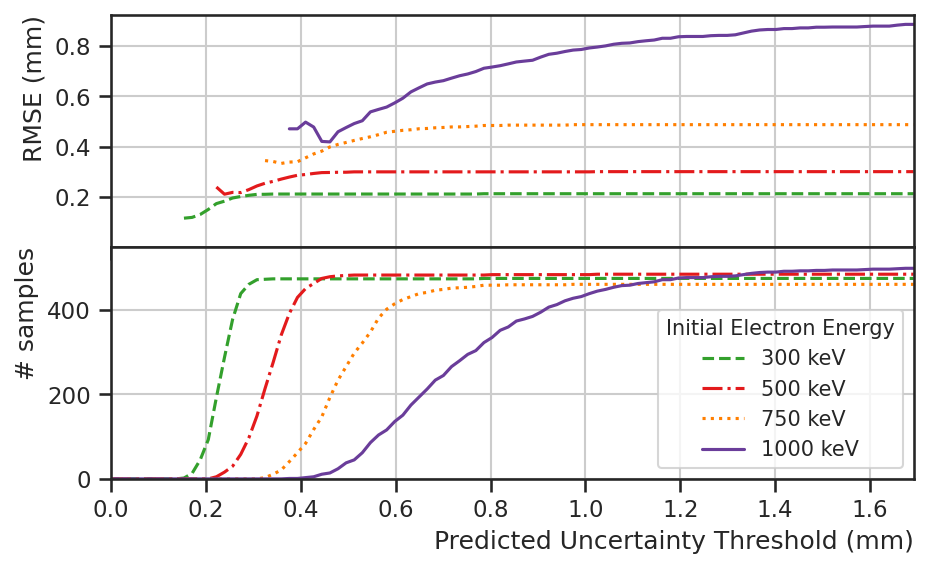

In [54]:
context = 'notebook'
style = 'ticks'
fmt='png'
sns.set_theme(context, style)
fig_dpi=150

fig, axes = plt.subplots(2, 1, dpi=fig_dpi, figsize = (6.4, 6.4/golden_ratio), sharex=True)

from matplotlib import lines
linestyles = list(lines.lineStyles.keys())[:4]
x = np.linspace(0, unc_rms.max(), 100)
hue_order = ['300 keV', '500 keV', '750 keV', '1000 keV']
for i in range(len(hue_order)):
    en = hue_order[i]
    rms = []
    N = []
    for xi in x:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            tmp_errors = mses[(df0[energy]!='300 keV')|((df0[energy]=='300 keV')&(rmses<1.0))]
            m,s,n = get_mean_std(tmp_errors[(unc_rms<xi)&(df0[energy]==en)], sigma=1.645)
            rms.append(np.sqrt(tmp_errors[(unc_rms<xi)&(df0[energy]==en)].mean()))
            N.append(n)
    axes[0].plot(x, rms, color=pal2[i+1], label=en, linestyle=linestyles[(i+1)%len(linestyles)])
    axes[1].plot(x, N, color=pal2[i+1], label=en, linestyle=linestyles[(i+1)%len(linestyles)])

axes[0].set_ylim([0.001, axes[0].get_ylim()[1]])#1])
axes[0].grid(which='major')

axes[1].set_xlim([x[0], x[-1]])
axes[1].set_ylim([0, 550])

if context=='paper':
    axes[0].set_ylabel('RMS Error (mm)', loc='top')
    axes[1].set_xlabel('Predicted Uncertainty Threshold (mm)', loc='right')
    axes[1].set_ylabel('Number of samples', loc='top')
else:
    axes[0].set_ylabel('RMSE (mm)', loc='top')
    axes[1].set_xlabel('Predicted Uncertainty Threshold (mm)', loc='right')
    axes[1].set_ylabel('# samples', loc='top')

axes[1].grid(which='major')
axes[1].legend(title='Initial Electron Energy', fontsize=10, title_fontsize=10, loc='lower right')

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig("unc_threshold_effects_edl_{0}_{1}.{2}".format(context, style, fmt), format=fmt)

## An example electron track

In [65]:
hue_order = ['50 keV', '300 keV', '500 keV', '750 keV', '1000 keV']
df_abs = pd.DataFrame(
    data={
        energy:np.concatenate([np.repeat(en, energies_test[energies_test==en].shape[0]) for en in hue_order]),
        abs_error:np.concatenate([np.sqrt(np.sum((errors[energies_test==en] - np.mean(errors[energies_test==en], axis=0))**2, axis=1)) for en in hue_order])*1000,
        squared_error:np.concatenate([np.sum(((errors[energies_test==en] - np.mean(errors[energies_test==en], axis=0))*1000)**2, axis=1) for en in hue_order])
    }
)

In [71]:
def plot_3D(i, x, y, z, hits, energies_test, origins=None, predictions=None, ids=None, id_predictions=None, unc_predictions=None, filename=None, fmt=None, figwidth=None, labelpad=None, fig_dpi=150):
    x_low = x[np.argmin(x*(hits[i]>0))]*1000
    x_up = x[np.argmax(x*(hits[i]>0))]*1000
    y_low = y[np.argmin(y*(hits[i]>0))]*1000
    y_up = y[np.argmax(y*(hits[i]>0))]*1000
    z_low = z[np.argmin(z*(hits[i]>0))]*1000
    z_up = z[np.argmax(z*(hits[i]>0))]*1000

    if figwidth is not None:
        fig = plt.figure(figsize=(figwidth,figwidth*3/4), dpi=fig_dpi)
    else:
        fig = plt.figure(dpi=fig_dpi)
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(energies_test[i]+" Electron track", pad=labelpad)
    ax.set_xlim([x_low, x_up])
    ax.set_ylim([y_low, y_up])
    ax.set_zlim([z_low, z_up])
    ax.set_xlabel('x (mm)', labelpad=labelpad)
    ax.set_ylabel('y (mm)', labelpad=labelpad)
    ax.set_zlabel('z (mm)', labelpad=labelpad)
    
    ax.scatter(x*1000, y*1000, z*1000, s=hits[i], alpha=0.1, c=hits[i], edgecolors='b', linewidth=0)
    if origins is not None:
        ax.scatter(origins[i,0]*1000, origins[i,1]*1000, origins[i,2]*1000, s=25, c=[[1.0, 0.4980392156862745, 0.054901960784313725]], label='True origin')
    if predictions is not None:
        ax.scatter(predictions[i,0]*1000, predictions[i,1]*1000, predictions[i,2]*1000, s=25, c=[[0.17254901960784313, 0.6274509803921569, 0.17254901960784313]], label='Predicted origin')
    if ids is not None and origins is not None:
        ax.quiver(origins[i,0]*1000, origins[i,1]*1000, origins[i,2]*1000, ids[i, 0]*1000*1.5, ids[i,1]*1000*1.5, ids[i,2]*1000*1.5, color=[[1.0, 0.4980392156862745, 0.054901960784313725]], label="True initial direction")
    if id_predictions is not None and predictions is not None:
        ax.quiver(predictions[i,0]*1000, predictions[i,1]*1000, predictions[i,2]*1000, id_predictions[i, 0]*1000*1.5, id_predictions[i,1]*1000*1.5, id_predictions[i,2]*1000*1.5, color=[[0.17254901960784313, 0.6274509803921569, 0.17254901960784313]], label="Predicted initial direction")
    if unc_predictions is not None and predictions is not None:
        rx, ry, rz = unc_predictions[i,0]*1000, unc_predictions[i,1]*1000, unc_predictions[i,2]*1000

        # Set of all spherical angles:
        u = np.linspace(0, 2 * np.pi, 100)
        v = np.linspace(0, np.pi, 100)

        # Cartesian coordinates that correspond to the spherical angles:
        # (this is the equation of an ellipsoid):
        x = rx * np.outer(np.cos(u), np.sin(v)) + 1000*predictions[i,0]
        y = ry * np.outer(np.sin(u), np.sin(v)) + 1000*predictions[i,1]
        z = rz * np.outer(np.ones_like(u), np.cos(v)) + 1000*predictions[i,2]
        ax.plot_surface(x, y, z,  color=[0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 0.2], linewidth=0.05)
        
    ax.legend()
    if filename is not None and fmt is None:
        plt.savefig(filename+'.png', format='png')
    elif filename is not None and fmt is not None:
        plt.savefig(filename+'.'+fmt, format=fmt)
    elif filename is None and fmt is not None:
        print("Cannot save with only format specification and no filename! Please supply filename.")

In [68]:
sorted_errs_1000_keV = ind[mses[df0[energy]=='1000 keV'].sort_values().index]
sorted_uncs_1000_keV = ind[unc_rms[df0[energy]=='1000 keV'].sort_values().index]
sorted_chi2_1000_keV = ind[chi2[df0[energy]=='1000 keV'].sort_values().index]

sorted_errs_300_keV = ind[mses[df0[energy]=='300 keV'].sort_values().index]
sorted_uncs_300_keV = ind[unc_rms[df0[energy]=='300 keV'].sort_values().index]
sorted_chi2_300_keV = ind[chi2[df0[energy]=='300 keV'].sort_values().index]

In [69]:
pitch_m = pitch/1e3
x_centers = np.arange(-(input_shape[1]-1)/2*pitch_m, (input_shape[1]-1)/2*pitch_m+pitch_m, pitch_m)
y_centers = np.arange(-(input_shape[2]-1)/2*pitch_m, (input_shape[2]-1)/2*pitch_m+pitch_m, pitch_m)
z_centers = np.arange(-(input_shape[3]-1)/2*pitch_m, (input_shape[3]-1)/2*pitch_m+pitch_m, pitch_m)

x = np.array([x for x in x_centers for y in y_centers for z in z_centers])
y = np.array([y for x in x_centers for y in y_centers for z in z_centers])
z = np.array([z for x in x_centers for y in y_centers for z in z_centers])

hits = np.reshape(X_test, (-1, len(x_centers)*len(y_centers)*len(z_centers)))*samples_scale

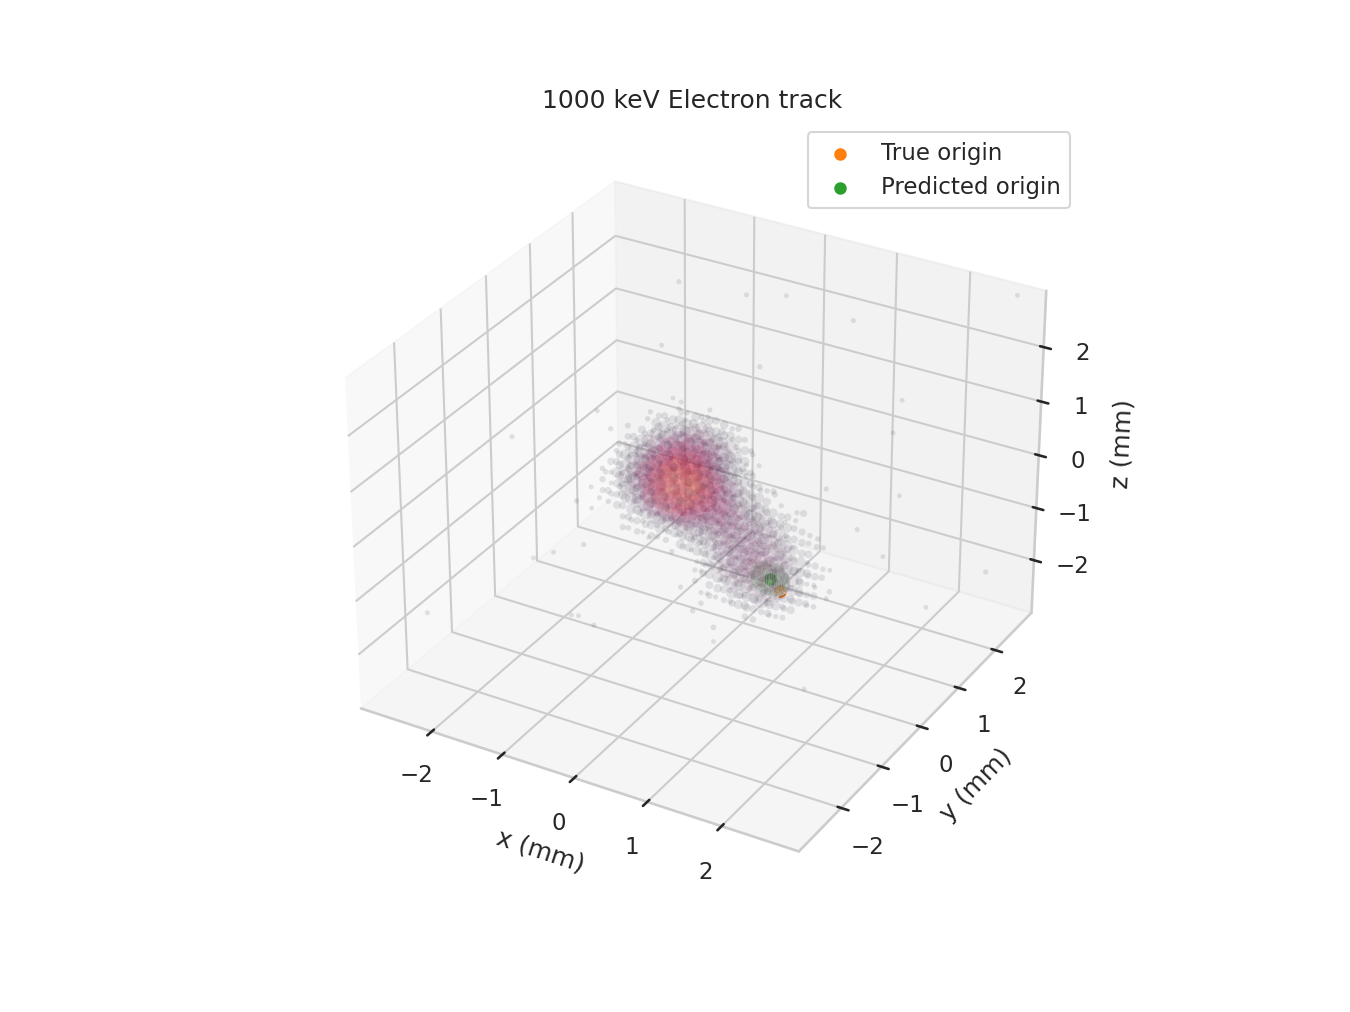

In [73]:
%matplotlib widget
fmt='pdf'
sns.set_theme(context='notebook', style='whitegrid')
plt.ion()
filename = '5_cm_least_err'
plot_3D(sorted_errs_1000_keV[0], x, y, z, hits, energies_test, origins=origins, predictions=predictions, unc_predictions=Stdpred*o_std+o_mean, figwidth=9, filename=filename, fmt=fmt)

## Plot results of parameterized response applied to simulated gamma-rays from MEGAlib/ComPair

This will only work for a 5cm drift length, since that is the only MEGAlib data that exists. The 5cm drift was chosen as a reasonable average drift length for all scatters, since it was infeasible to insert a response that was parameterized over the drift length in addition to energy.

In [55]:
with open("drift_{0}cm_1.000MeV_Cos0.8_boggs_data_untracked.pkl".format(drift), 'rb') as f:
    boggs_data = pd.DataFrame(pl.load(f))
boggs_data['boggs_dphi'] = np.sqrt(boggs_data['boggs_dphi_r']**2+boggs_data['phi_Theoretical_error']**2)

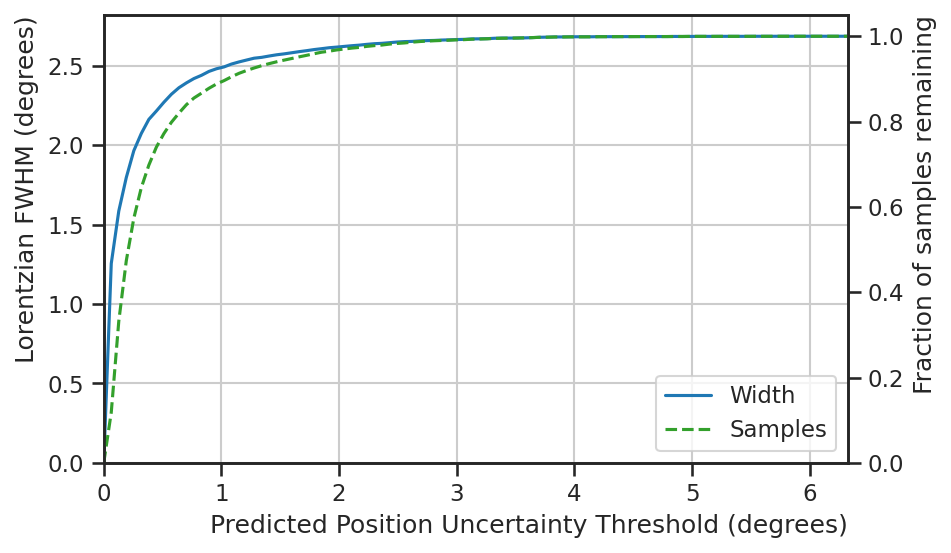

In [60]:
context = 'notebook'
style = 'ticks'
fmt='png'
sns.set_theme(context, style)
fig_dpi=150

fig, ax = plt.subplots(dpi=fig_dpi, figsize = (6.4, 6.4/golden_ratio))

tmp_data = boggs_data[boggs_data['misreconstructed']==False]
x = np.linspace(0, boggs_data['boggs_dphi_r'].max(), 100)
gamma = []
N = []
for xi in x:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        n = len(tmp_data[(tmp_data['boggs_dphi_r']<xi)]['dphi'])
        if n>0:
            gamma.append(scipy.stats.cauchy.fit(tmp_data[(tmp_data['boggs_dphi_r']<xi)]['dphi'])[1])
        else:
            gamma.append(0)
        N.append(n)
l1, = ax.plot(x, 2*np.array(gamma), color=pal2[0], linestyle=linestyles[0], label='Width') # 2*gamma is FWHM
ax_twin = ax.twinx()
l2, = ax_twin.plot(x, np.array(N)/N[-1], color=pal2[1], linestyle=linestyles[1], label='Samples')
    
ax.set_ylim([0, ax.get_ylim()[1]])#1])
if context=='paper' or context=='notebook':
    ax.set_xlabel('Predicted Position Uncertainty Threshold (degrees)', loc='right')
    ax.set_ylabel('Lorentzian FWHM (degrees)', loc='top')
    ax_twin.set_ylabel('Fraction of samples remaining', loc='top')
elif context=='talk' or context=='poster':
    ax.set_xlabel('Pos. Unc. Thresh. (deg.)', loc='right')
    ax.set_ylabel('Lor. FWHM (deg.)', loc='top')
    ax_twin.set_ylabel('Frac. samp. remain.', loc='top')
ax.grid(which='both')

ax_twin.set_xlim([x[0], x[-1]])
ax_twin.set_ylim([0, ax_twin.get_ylim()[-1]])
ax.legend([l1, l2], ['Width', 'Samples'], loc='lower right')

if SAVE_FIGURES:
    plt.savefig('lorentzian_width_vs_unc_threshold_{0}_{1}.{2}'.format(context, style, fmt), bbox_inches='tight', format=fmt)

In [58]:
def voigt_func(x, amplitude, offset, sigma, gamma):
    return amplitude * scipy.special.voigt_profile(x - offset, sigma, gamma)

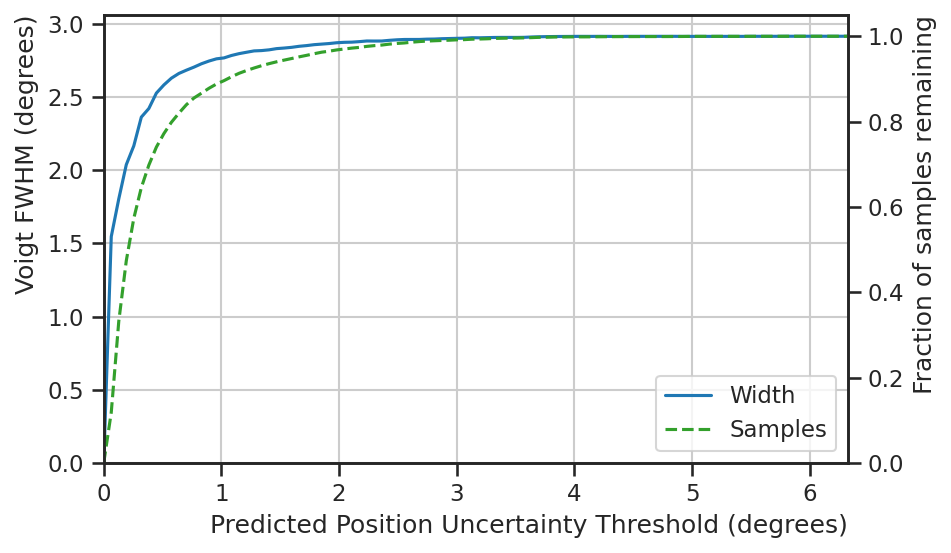

In [61]:
# Try a Voigt profile
context = 'notebook'
style = 'ticks'
fmt='png'
fig_dpi=150
sns.set_theme(context, style)

fig, ax = plt.subplots(dpi=fig_dpi, figsize = (6.4, 6.4/golden_ratio))

tmp_data = boggs_data[boggs_data['misreconstructed']==False]
x = np.linspace(0, boggs_data['boggs_dphi_r'].max(), 100)
FWHM = []
gamma = []
sigma = []
offset = []
amplitude = []
N = []
for xi in x:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        tmp_data_selected = tmp_data[(tmp_data['boggs_dphi_r']<xi)]
        n = len(tmp_data_selected['dphi'])
        if n>0:
            dphi_binned, bin_edges = np.histogram(tmp_data_selected['dphi'], bins=100)
            bincenters = bin_edges[:-1] + np.diff(bin_edges)/2
            # I tried inheriting from scipy.stats.rv_continuous, but could not get it to work correctly
            params, _ = scipy.optimize.curve_fit(voigt_func, bincenters, dphi_binned, p0=[n, 0, 1, 1], bounds=([0, -np.inf, 0, 0], np.inf))
            amplitude.append(params[0])
            offset.append(params[1])
            sigma.append(params[2])
            gamma.append(params[3])
            FWHM_gaus = 2*sigma[-1]*np.sqrt(2*np.log(2))
            FWHM_lorentz = 2*gamma[-1]
            FWHM.append(FWHM_lorentz/2 + np.sqrt(FWHM_lorentz**2/4 + FWHM_gaus**2)) # https://en.wikipedia.org/wiki/Voigt_profile#The_width_of_the_Voigt_profile
        else:
            FWHM.append(0)
        N.append(n)
l1, = ax.plot(x, np.array(FWHM), color=pal2[0], linestyle=linestyles[0], label='Width') # 2*gamma is FWHM
ax_twin = ax.twinx()
l2, = ax_twin.plot(x, np.array(N)/N[-1], color=pal2[1], linestyle=linestyles[1], label='Samples')
    
ax.set_ylim([0, ax.get_ylim()[1]])#1])
if context=='paper' or context=='notebook':
    ax.set_xlabel('Predicted Position Uncertainty Threshold (degrees)', loc='right')
    ax.set_ylabel('Voigt FWHM (degrees)', loc='top')
    ax_twin.set_ylabel('Fraction of samples remaining', loc='top')
elif context=='talk' or context=='poster':
    ax.set_xlabel('Pos. Unc. Thresh. (deg.)', loc='right')
    ax.set_ylabel('Voigt FWHM (deg.)', loc='top')
    ax_twin.set_ylabel('Frac. samp. remain.', loc='top')
ax.grid(which='both')

ax_twin.set_xlim([x[0], x[-1]])
ax_twin.set_ylim([0, ax_twin.get_ylim()[-1]])
ax.legend([l1, l2], ['Width', 'Samples'], loc='lower right')

if SAVE_FIGURES:
    plt.savefig('voigt_width_vs_unc_threshold_{0}_{1}.{2}'.format(context, style, fmt), bbox_inches='tight', format=fmt)

In [62]:
y = np.linspace(0, tmp_data['boggs_dphi_r'].max(), 100)
x = np.linspace(0, tmp_data['boggs_dphi_r'].max(), 100)
gamma = []
N = []
for xi in x:
    gamma_x = []
    N_x = []
    for yi in y:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            n = len(tmp_data[(tmp_data['boggs_dphi_r']<yi)&(tmp_data['phi_Theoretical_error']<xi)])
            if n>0:
                gamma_x.append(scipy.stats.cauchy.fit(tmp_data[(tmp_data['boggs_dphi_r']<yi)&(tmp_data['phi_Theoretical_error']<xi)]['dphi'])[1])
            else:
                gamma_x.append(0)
            N_x.append(n)
    gamma.append(gamma_x)
    N.append(N_x)

gamma = np.array(gamma)
N = np.array(N)

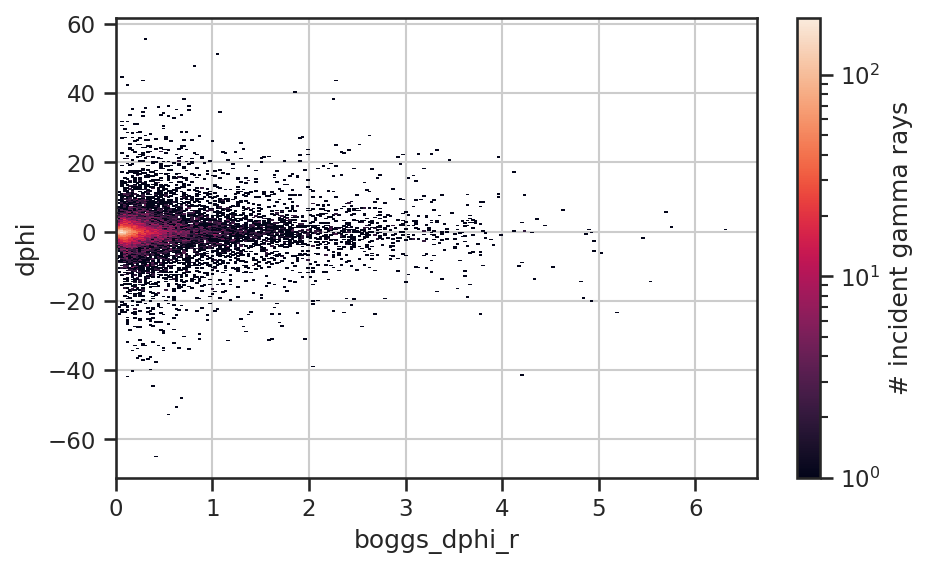

In [63]:
import matplotlib.colors as mcolors
context = 'notebook'
style = 'ticks'
fmt='png'
sns.set_theme(context, style)
fig_dpi=150

fig = plt.figure(dpi=fig_dpi, figsize = (6.4, 6.4/golden_ratio))
ax = sns.histplot(data=boggs_data[boggs_data['misreconstructed']==False], y='dphi', x='boggs_dphi_r', cbar=True, cbar_kws=dict(label='# incident gamma rays'), cmap='rocket', norm=mcolors.LogNorm(), vmin=None, vmax=None)
if context=='paper':
    ax.set_xlabel('Predicted Position Uncertainty (degrees)', loc='right')
    ax.set_ylabel('Reconstructed Gamma-Ray Origin Error (degrees)', loc='top')
elif context=='talk' or context=='poster':
    ax.set_xlabel('Pos. Unc. (degrees)', loc='right')
    ax.set_ylabel('$\gamma$ Origin Err. (degrees)', loc='top')
ax.set_xlim([0, ax.get_xlim()[1]])
ax.grid(which='major')

plt.tight_layout()
plt.savefig('err_vs_pred_unc_{0}_{1}.{2}'.format(context, style, fmt), bbox_inches='tight', format=fmt)

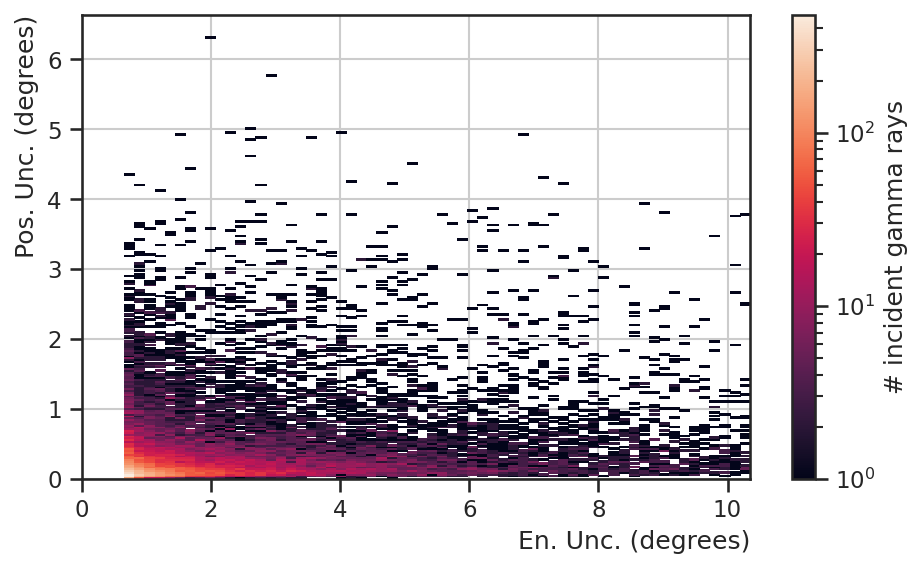

In [64]:
context = 'notebook'
style = 'ticks'
fmt='png'
sns.set_theme(context, style)
fig_dpi=150

fig = plt.figure(dpi=fig_dpi, figsize = (6.4, 6.4/golden_ratio))
ax = sns.histplot(data=boggs_data[(boggs_data['misreconstructed']==False)&(boggs_data['phi_Theoretical_error']<(6.4*golden_ratio))], y='boggs_dphi_r', x='phi_Theoretical_error', cbar=True, cbar_kws=dict(label='# incident gamma rays'), cmap='rocket', norm=mcolors.LogNorm(), vmin=None, vmax=None)

ax.set_ylabel('Pos. Unc. (degrees)', loc='top')
ax.set_xlabel('En. Unc. (degrees)', loc='right')
ax.set_xlim([0, 6.4*golden_ratio])
ax.set_ylim([0, ax.get_ylim()[1]])
ax.grid(which='major')

plt.tight_layout()
if SAVE_FIGURES:
    plt.savefig('pos_unc_vs_en_unc_{0}_{1}.{2}'.format(context, style, fmt), bbox_inches='tight', format=fmt)